<a href="https://colab.research.google.com/github/zcwisc/GB657/blob/main/Module_2_RegressionTreesandBagging_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Regression Trees and Bagging

In this tutorial, we will introduce regression trees and bagging.  We consider a basic simulated example with a single predictor that compares tress to (linear) regression.  In particular, we will demonstrate when trees do well and when the don't.

As usually, let's start with loading the relevant libaries.

In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import graphviz
import pydot

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error

# Regression Trees

## Review of Concepts and Maths

### Trees

As we discuss in the previous parts, trees successively split the domains of predictors into two areas (greater and smaller), so that the final tree can be thought of as a model with constant predictions in *square partitions* of the feature domain.  Hence, in building a tree, we need to address two questions:

1. <span style="color:blue"> How to come up with the splits that determine the square partitions? </span>

2. <span style="color:blue"> How to come up with the predictions for each of the square partitions? </span>

The second task is straightforward:  We simply take the average of all predictions in the current partition.  

For 2., one relies on a *greedy algorithm*: For each node, we go over all possible variables and all possible split levels, and then choose the combination of variable and split level that mimizes the prediction error.  However, note that the tree thus will generally not minimize the squared prediction error -- finding such a partition is computationally/algorithmically infeasible...

### Excursion: The Sigmoid Function

In generating our dataset we will use the so-called *sigmoid function*, which will be a key ingredient when we discuss *neural networks*.  It has the advantage that depending on the choice of a parameter, it can mimic a highly linear or a highly non-linear relationship:

$$
\sigma_{\alpha}(x) = \frac{1}{1+e^{-\alpha\,x}}
$$


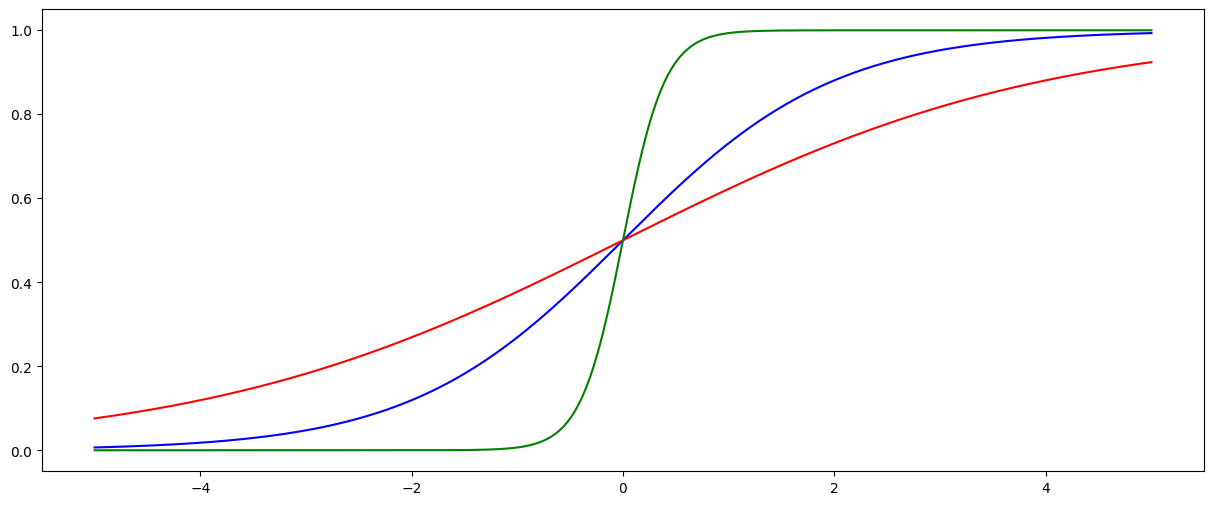

In [2]:
def sigmoid(x):
    return(1 / (1 + np.exp(-x)))
x = np.linspace(-5, 5, 1000)
plt.figure(figsize=(15,6))
plt.plot(x, sigmoid(x), color='b')
plt.plot(x, sigmoid(0.5*x), color='r')
plt.plot(x, sigmoid(5*x), color='g')

So we notice that for a small choice of $\alpha$ (red curve), we obtain a relationship that is almost linear (and, indeed, as $\alpha$ becomes smaller and smaller, $\sigma_{\alpha}$ approaches a perfectly linear function).  Whereas for a larger choice of $\alpha$ (green curve), we almost obtain a step function (and, indeed, as $\alpha$ becomes larger and larger, $\sigma_{\alpha}$ approaches a step function).

## A Simulated Example with One Predictor

1. Let's start by generating two datasets based on the sigmoid function with different parameters taken from above.

In [128]:
np.random.seed(42) #Set a random seed for obtaining the same results every time we run the code
x = 3 * np.random.normal(0, 1, 150)
eps = 0.25 * np.random.normal(0, 1, 150)

y_1 = sigmoid(0.5 * x) + eps
y_2 = sigmoid(5 * x) + eps


Here is the first dataset:

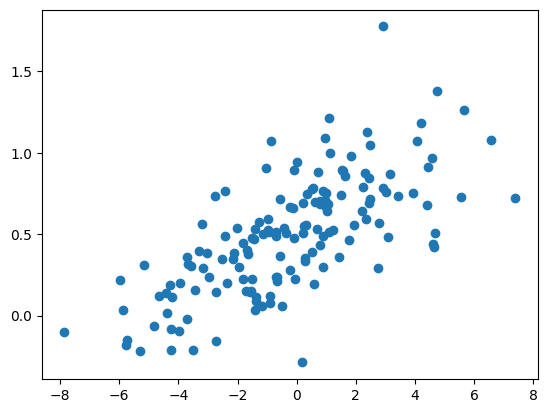

In [129]:
mydata1 = pd.DataFrame({'y_1':y_1,'x':x})
mytraindata1 = mydata1[0:100]
mytestdata1 = mydata1[100:150]

plt.scatter(mydata1.x,mydata1.y_1)

And here is the second dataset:

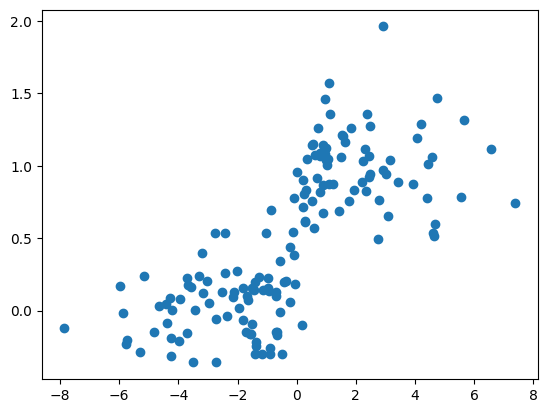

In [130]:
mydata2 = pd.DataFrame({'y_2':y_2,'x':x})
mytraindata2 = mydata2[0:100]
mytestdata2 = mydata2[100:150]
plt.scatter(mydata2.x,mydata2.y_2)

2. And, for comparison, let's fit a linear regression model to both datasets and let's evaluate the out-of-sample error.

In [131]:
X_1train = mytraindata1['x'].values.reshape(-1,1)
X_1test = mytestdata1['x'].values.reshape(-1,1)
y_1train = mytraindata1['y_1'].values
lmfit1 = LinearRegression(fit_intercept=True)
lmfit1.fit(X_1train,y_1train)
yhat_OOS1 = lmfit1.predict(X_1test)
OLS_OOS_MSE1 = sum((mytestdata1['y_1'] - yhat_OOS1)**2)/50
OLS_OOS_MSE1

0.07329761448829633

In [132]:
X_2train = mytraindata2['x'].values.reshape(-1,1)
X_2test = mytestdata2['x'].values.reshape(-1,1)
y_2train = mytraindata2['y_2'].values
lmfit2 = LinearRegression(fit_intercept=True)
lmfit2.fit(X_2train,y_2train)
yhat_OOS2 = lmfit2.predict(X_2test)
OLS_OOS_MSE2 = sum((mytestdata2['y_2'] - yhat_OOS2)**2)/50
OLS_OOS_MSE2

0.11598948689350942

3. Let's fit a tree to the second dataset.

In [133]:
tree2 = DecisionTreeRegressor(max_leaf_nodes=3)
tree2.fit(X_2train, y_2train)

DecisionTreeRegressor(max_leaf_nodes=3)

The following function creates images of tree models using pydot, as the package sklearn doesn't offer graphs of the trees


In [134]:
import pydot
from IPython.display import Image
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names

    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

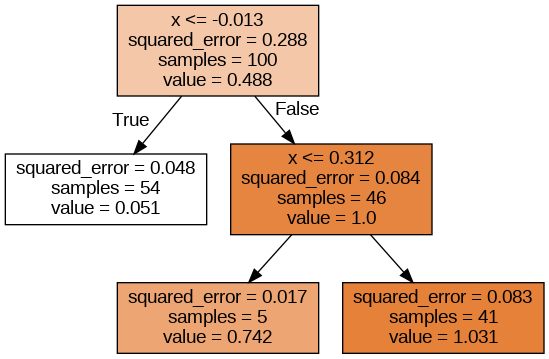

In [136]:
graph, = print_tree(tree2, features=['x'])
Image(graph.create_png())

4. Let's use the test data and cross validation to see what size is optimal, and let's prune accordingly.

In [137]:
from sklearn.model_selection import cross_val_score
OLS_OOS_MSE2 = []
cv_score = []
for i in range(2,6):
    tree2 = DecisionTreeRegressor(max_leaf_nodes=i)
    tree2.fit(X_2train, y_2train)
    ytreehat2 = tree2.predict(X_2test)
    OLS_OOS_MSE2.append(sum((mytestdata2['y_2'] - ytreehat2)**2)/50)
    cv_score.append(sum(cross_val_score(tree2, X_2train, y_2train, cv=5)))

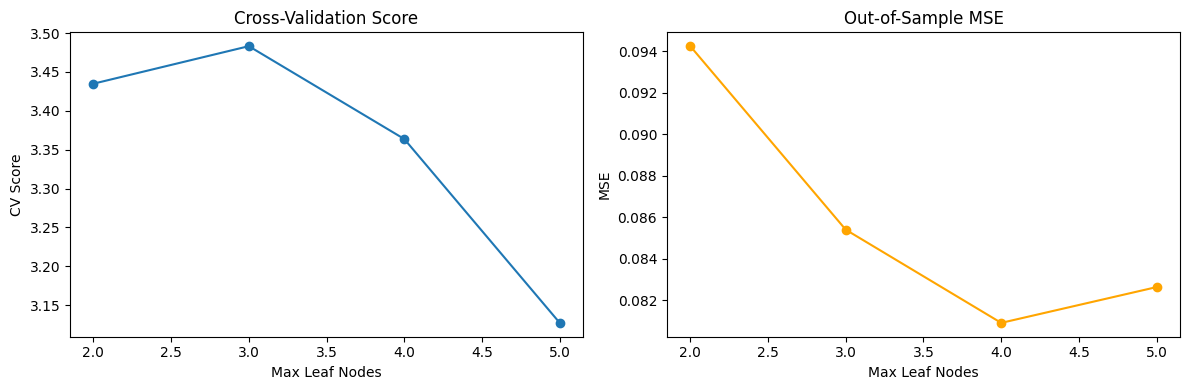

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(2, 6), cv_score, marker='o')
axes[0].set_title('Cross-Validation Score')
axes[0].set_xlabel('Max Leaf Nodes')
axes[0].set_ylabel('CV Score')

axes[1].plot(range(2, 6), OLS_OOS_MSE2, marker='o', color='orange')
axes[1].set_title('Out-of-Sample MSE')
axes[1].set_xlabel('Max Leaf Nodes')
axes[1].set_ylabel('MSE')

plt.tight_layout()
plt.show()

So it looks that the simplest tree with only three leaves does best.

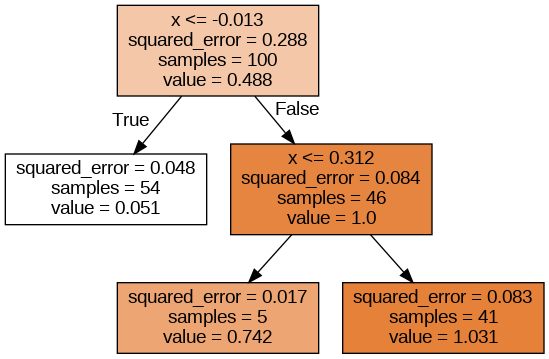

In [139]:
tree2 = DecisionTreeRegressor(max_leaf_nodes=3)
tree2.fit(X_2train, y_2train)
graph, = print_tree(tree2, features=['x'])
Image(graph.create_png())

In [140]:
ytreehat2 = tree2.predict(X_2test)
test_mse = mean_squared_error(mytestdata2['y_2'], ytreehat2)
print(f"Test MSE for tree2: {test_mse}")

Test MSE for tree2: 0.0854032978267664


5. Let's redo for the first dataset.

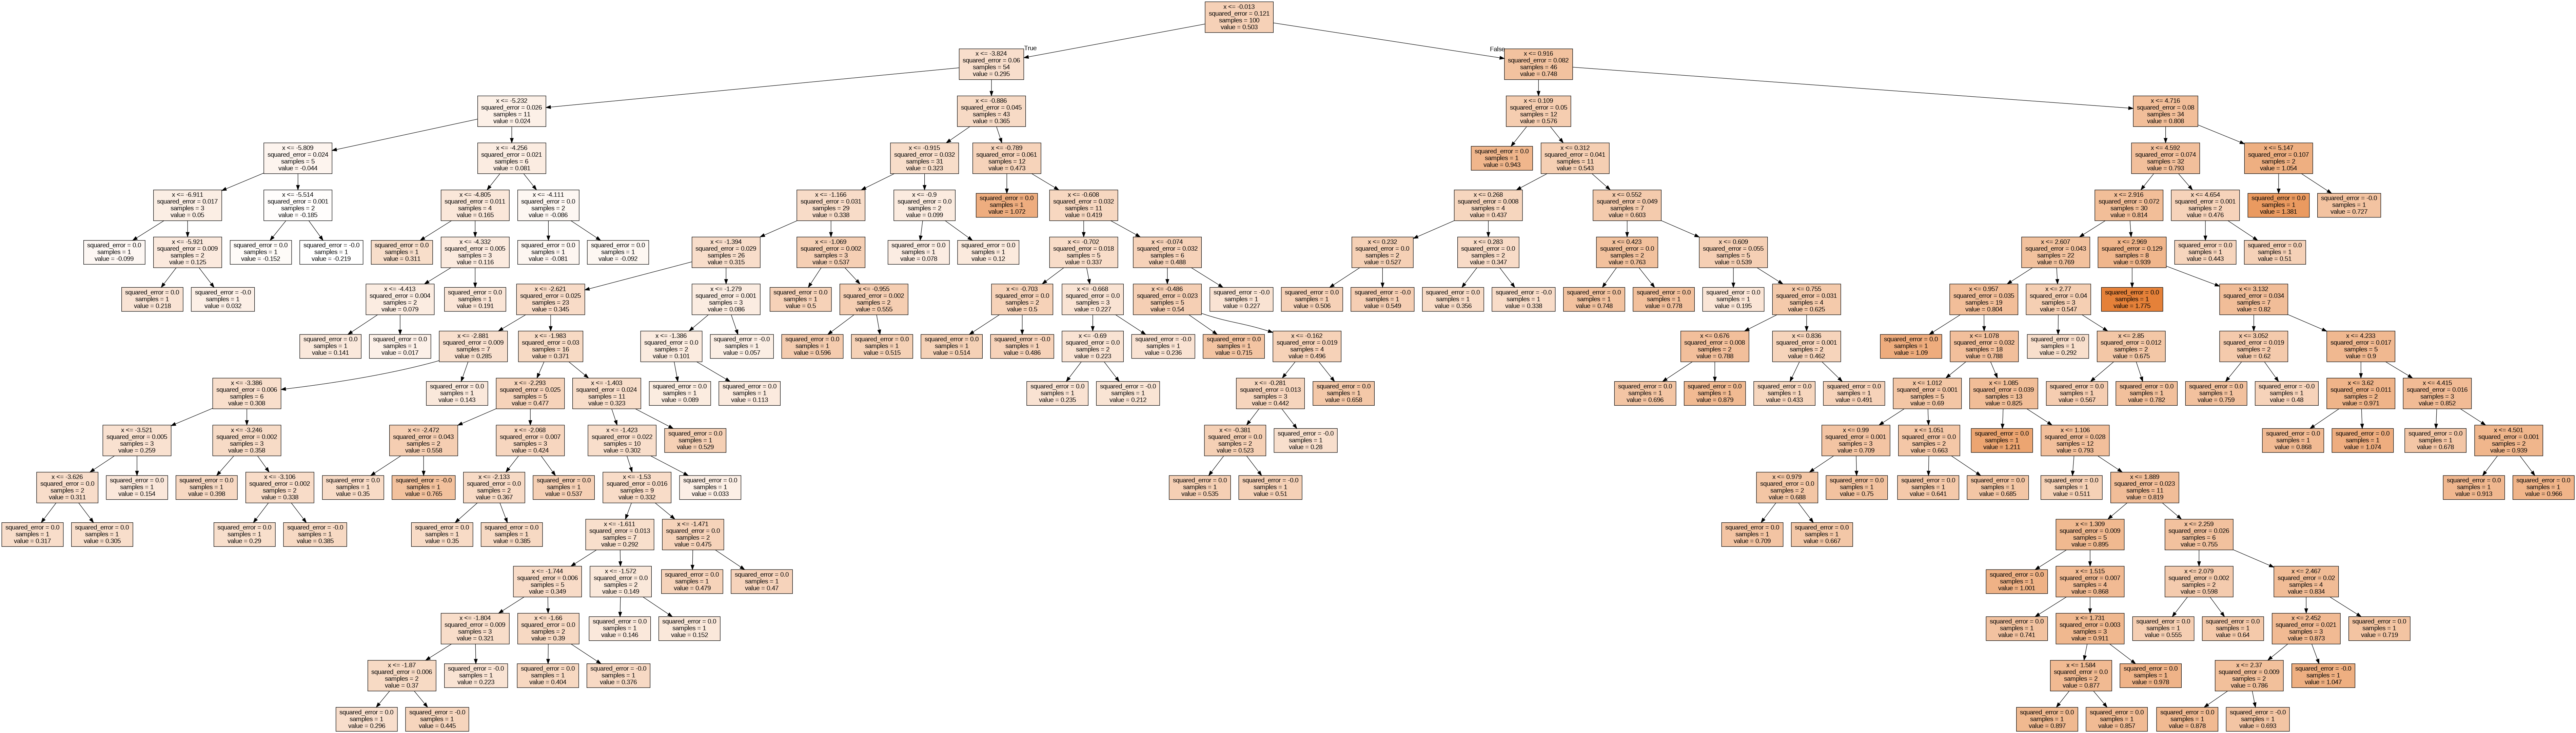

In [141]:
tree1 = DecisionTreeRegressor()
tree1.fit(X_1train, y_1train)
graph, = print_tree(tree1, features=['x'])
Image(graph.create_png())

In [142]:
OLS_OOS_MSE1 = []
cv_score = []
for i in range(2,7):
    tree1 = DecisionTreeRegressor(max_leaf_nodes=i)
    tree1.fit(X_1train, y_1train)
    ytreehat1 = tree1.predict(X_1test)
    OLS_OOS_MSE1.append(sum((mytestdata1['y_1'] - ytreehat1)**2)/50)
    cv_score.append(sum(cross_val_score(tree1, X_1train, y_1train, cv=5)))

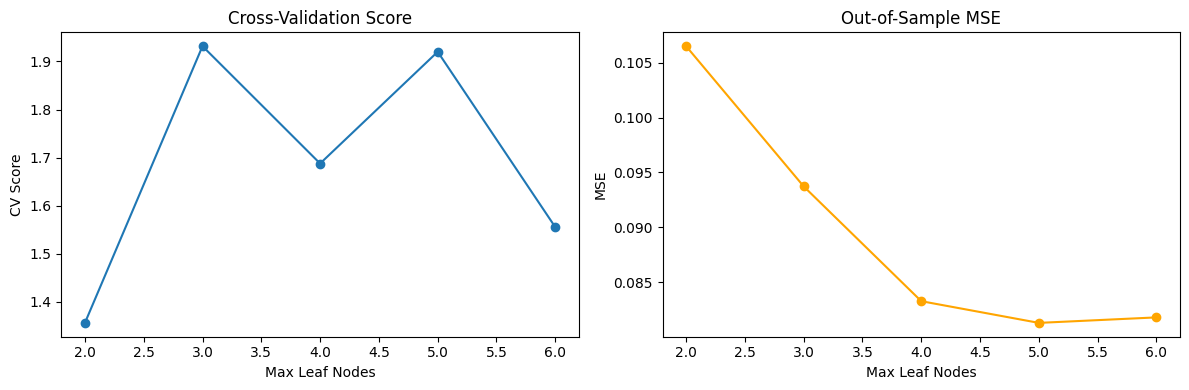

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(2, 7), cv_score, marker='o')
axes[0].set_title('Cross-Validation Score')
axes[0].set_xlabel('Max Leaf Nodes')
axes[0].set_ylabel('CV Score')

axes[1].plot(range(2, 7), OLS_OOS_MSE1, marker='o', color='orange')
axes[1].set_title('Out-of-Sample MSE')
axes[1].set_xlabel('Max Leaf Nodes')
axes[1].set_ylabel('MSE')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

So ot looks like 3 leaves is optimal. Let's prune:

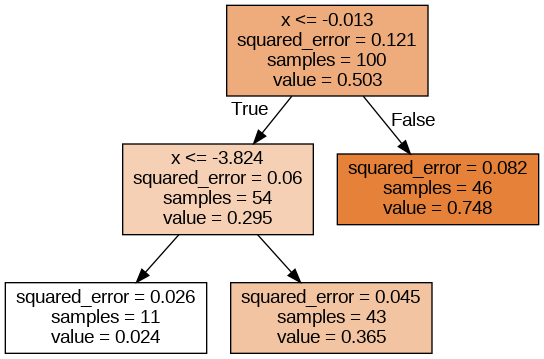

In [144]:
tree1 = DecisionTreeRegressor(max_leaf_nodes=3)
tree1.fit(X_1train, y_1train)
graph, = print_tree(tree1, features=['x'])
Image(graph.create_png())

In [145]:
ytreehat1 = tree1.predict(X_1test)
test_mse = mean_squared_error(mytestdata1['y_1'], ytreehat1)
print(f"Test MSE for tree1: {test_mse}")

Test MSE for tree1: 0.09372743586756604


Hence, the tree performs very differently between the two datasets:  For the second dataset, the tree provided a very simple (and understandable!) model of the data, and despite the simplicity the prediction accuracy improved relative to the linear regressions.  For the first dataset, on the other hand, the tree is far more complex than the regression model but still provides worse predictions.

Hence, overall, trees are well-suited for modeling non-linear relationships -- which explains their relevance as the foundational structural element for more advanced learners.

# Bagging

In this tutorial, we discuss approaches to improve on the predictive porformance of CARTs via *aggregation*. We consider a basic bootstrap aggregation approach in the context of a simple example with a single predictor, illustrating key aspects and pitfalls.

As usually, let's start with loading the relevant libaries.

## Improvement via Aggregation

### Review of Concepts and Maths

As discussed in GB 656, there is a key tradeoff between *bias* and *variance*:  A more complex learner may perform marvelously *in-sample*, but the *out-of-sample* performance is poor due to *overfitting*.  *Ensemble* learning techniques use the input from basic learners trained on different data sets (or also the input from different learners trained on the same data set -- this is referred to as *stacking*), to improve on the predictive performance of the basic learner.

In *Bagging* -- short for *bootstrap-aggregating* -- the idea is to sample from the original dataset to obtain $M$ bootstrap samples, which are in turn used for training the predictive model yielding predictions $\hat{Y}_j,$ $j=1,\ldots,M.$  The final prediction $\hat{Y}$ then is based on the average of the different predictions: $\hat{Y} = \frac{1}{M} \sum_{j=1}^M \hat{Y}_j$.  

For instance, if each of the $M$ predictions is *unbiased*, $\mathbb{E}_x[\hat{Y}_i] = Y,$ then of course the aggregated prediction will be unbiased as well: $\mathbb{E}_x[\hat{Y}] = Y.$ However, we generally have for the standard deviation:
$$
\text{StDev}_x(\hat{Y}) = \frac{1}{N} \text{StDev}_x\left(\sum_{j=1}^M \hat{Y}_j\right) \leq \frac{1}{N} \sum_{j=1}^M \text{StDev}_x(Y_j),
$$
where the inequality is sharp if the predictions are not perfectly positively correlated.  Hence, aggregating can reduce the variance!

### A Simulated Example with One Predictor

Let us revisit the simple example from the previous tutorial on trees.  As a reminder, there we used the so-called *sigmoid* function that can depict highly linear as well as highly non-linear relationships by different choices of its parameter.  We used different parameters to generate two data sets, and compared the predictive preformance of trees vs. that of OLS regression.  Our conclusion was that trees work well in the non-linear situation whereas (linear) regression works well in the linear situation.

Now, rather than generating one tree, let's contemplate an alternative.  Let us draw new data sets from sampling from the original data set (*bootstrapping*), let's fit an (unpruned) tree to each of the sampled data sets, and let's predict by averaging over the predictions of these new trees.

In [158]:
ybaggedtreehat1 = np.zeros(mytestdata1['y_1'].shape)
atree = DecisionTreeRegressor()
# Reset index to start from 0 for correct sampling
mytraindata1_reset = mytraindata1.reset_index(drop=True)
for i in range(0, 1000):
  subset = np.random.choice(len(mytraindata1_reset), 25, replace=True)
  X = mytraindata1_reset['x'][subset].values.reshape(-1, 1)
  y = mytraindata1_reset['y_1'][subset].values
  atree.fit(X, y)
  ybaggedtreehat1 = ybaggedtreehat1 + atree.predict(mytestdata1['x'].values.reshape(-1, 1))
ybaggedtreehat1 = ybaggedtreehat1/1000
BAGGED_MSE1 = sum((mytestdata1['y_1'] - ybaggedtreehat1)**2)/50
BAGGED_MSE1

0.076026748236575

We notice that by aggregating, the tree-based predictions perform notably better than the single tree.  What is going on?  There are two aspects worth noting:

1. As explained above, by aggregating the individual trees we potentially reduce the variance of the prediction.

2. We are not pruning the individual trees which leads to lower bias.  While this may lead to overfitting by any individual tree, we control the variance by subsequently averaging.  Thus,  we potentially reduce the bias of the prediction.

Let's compare the predictions:

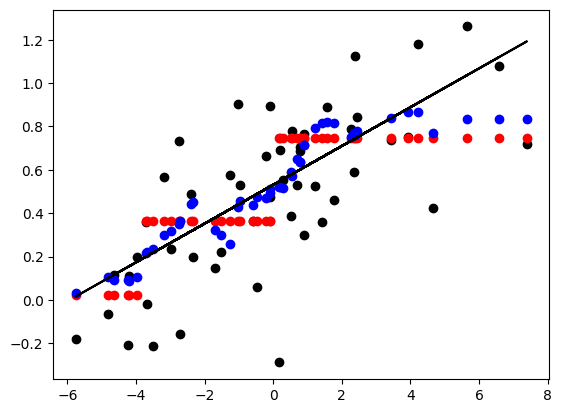

In [159]:

plt.scatter(mytestdata1['x'], mytestdata1['y_1'], c = 'k')
plt.plot(mytestdata1['x'], yhat_OOS1, c = 'k')
plt.scatter(mytestdata1['x'], ytreehat1, c = 'r')
plt.scatter(mytestdata1['x'], ybaggedtreehat1, c = 'b')

Let's also try the second dataset:

In [160]:
ybaggedtreehat2 = np.zeros(mytestdata2['y_2'].shape)
atree = DecisionTreeRegressor()
# Reset index to start from 0 for correct sampling
mytraindata2_reset = mytraindata2.reset_index(drop=True)
for i in range(0, 1000):
  subset = np.random.choice(len(mytraindata2_reset), 30, replace=True)
  X = mytraindata2_reset['x'][subset].values.reshape(-1, 1)
  y = mytraindata2_reset['y_2'][subset].values
  atree.fit(X, y)
  ybaggedtreehat2 = ybaggedtreehat2 + atree.predict(mytestdata2['x'].values.reshape(-1, 1))
ybaggedtreehat2 = ybaggedtreehat2/1000
BAGGED_MSE2 = sum((mytestdata2['y_2'] - ybaggedtreehat2)**2)/50
BAGGED_MSE2

0.07585010826905872

So it turns out here the aggregated sample beats even the basic tree model, which performed quite well.  But why?  Let's look at the predictions:

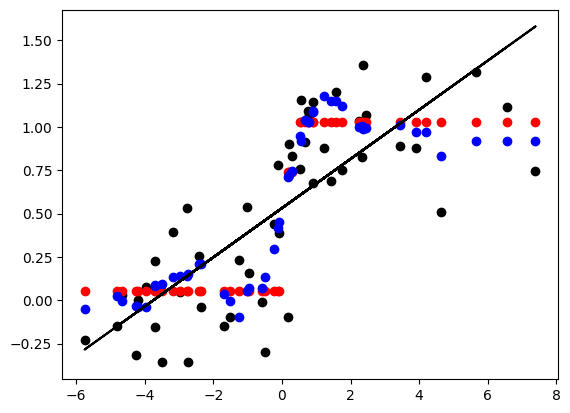

In [161]:
plt.scatter(mytestdata2['x'], mytestdata2['y_2'], c = 'k')
plt.plot(mytestdata2['x'], yhat_OOS2, c = 'k')
plt.scatter(mytestdata2['x'], ytreehat2, c = 'r')
plt.scatter(mytestdata2['x'], ybaggedtreehat2, c = 'b')